# Descrição da atividade:
Implementar e comparar dois modelos de autoencoder para redução de dimensionalidade e agrupamento:
- Arquitetura proposta com base teórica;
- Arquitetura otimizada por método de busca automática (ex.: Optuna).


## Para realizar esta atividade, optamos pela seguinte estrutura:
1. Primeiro analisar o dataset que será utilizando, tentando entender sua estrutura e características;
2. Realizar um treinamento *supervisionado* apenas para estabelecer uma referência de comparação;
3. Iniciar o treinamento *não supervisionado*: implementar um autoencoder com configuração manual de hiperparâmetros (arquitetura proposta com base teórica), combinado com K-means para clustering;
4. Aplicar o Optuna para maximizar a qualidade dos cluters formados.


In [31]:
# Importações básicas
import os
import numpy as np
import random
import json
import pathlib
import tempfile
import pandas as pd
import matplotlib.pyplot as plt

# Sklearn
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import train_test_split

# Tensorflow e Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras import backend as K

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Optuna
import optuna
from collections import Counter

def set_seed(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

# Carregamento do Dataset
Nesta etapa, importamos o dataset Iris a partir da biblioteca scikit-learn através da função `datasets.load_iris()`. 

In [32]:
# ---- Baseline
if __name__ == "__main__":
    set_seed(42)

    iris = datasets.load_iris(return_X_y = True)

    X = iris[0]
    y = iris[1]
    
    X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
X_all, y_all, n_clusters = X, y, 3
    
dataset_name = "Iris"
        

# Exploração Visual do Dataset Iris
Antes de iniciar o treinamento, vamos visualizar a distribuição das características das flores para compreender melhor os padrões presentes nos dados. 

In [33]:
if __name__ == "__main__":
    input_dim = X_all.shape[1]
    print('###############################################')
    print('# DataSet Iris                                #')    
    print('###############################################')
    print(f"Dataset: {dataset_name} | Quantidade de Registros: {len(X_all)} | input_dim={input_dim} | n_clusters={n_clusters}")
    print('')
    print('Informações do DataSet que estamos importando:') 
    print('input_dim = 4 -> Cada flor tem 4 atributos de entrada, conforme lista abaixo: ') 
    print(datasets.load_iris()['feature_names'])
    print('')
    print('n_clusters = 3 -> O objetivo é que o algoritmo de clusterização forme 3 grupos ') 
    print(datasets.load_iris()['target_names'])


###############################################
# DataSet Iris                                #
###############################################
Dataset: Iris | Quantidade de Registros: 150 | input_dim=4 | n_clusters=3

Informações do DataSet que estamos importando:
input_dim = 4 -> Cada flor tem 4 atributos de entrada, conforme lista abaixo: 
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

n_clusters = 3 -> O objetivo é que o algoritmo de clusterização forme 3 grupos 
['setosa' 'versicolor' 'virginica']


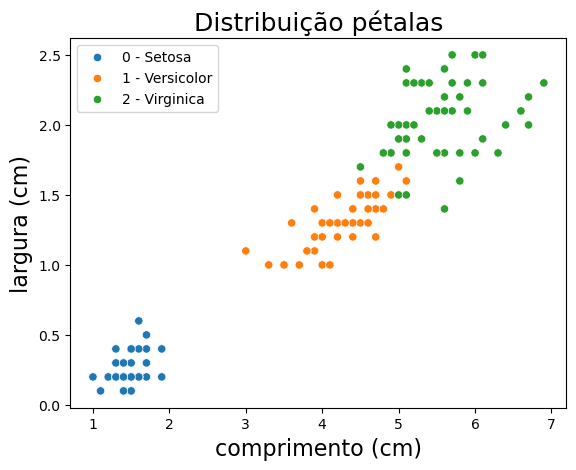

In [34]:
if __name__ == "__main__":

    sns.scatterplot(
        x=X_all[:, 2],   # petal length (cm)
        y=X_all[:, 3],   # petal width (cm)
        hue=y_all,
        palette="tab10"
    )
    plt.xlabel('comprimento (cm)', fontsize = 16)
    plt.ylabel('largura (cm)', fontsize = 16)
    plt.title('Distribuição pétalas', fontsize = 18)
    #plt.show()  

    nomes = ['0 - Setosa', '1 - Versicolor', '2 - Virginica']  # na mesma ordem de 0,1,2
    handles, labels = plt.gca().get_legend_handles_labels()
    # o primeiro label costuma ser o título automático ("hue")
    plt.legend(handles=handles[0:], labels=nomes)

    plt.show()


## Análise da Distribuição das Pétalas no dataset utilizado.

Do gráfico acima, observamos padrões importantes:
1) **Sobreposição entre classes**: As flores *Versicolor* e *Virginica* apresentam características de pétalas similares, com valores parcialmente sobrepostos tanto em comprimento quanto em largura.
2) **Separabilidade da Setosa**: As flores *Setosa* possuem pétalas significativamente menores, formando um cluster bem distinto e facilmente separável das outras duas espécies.

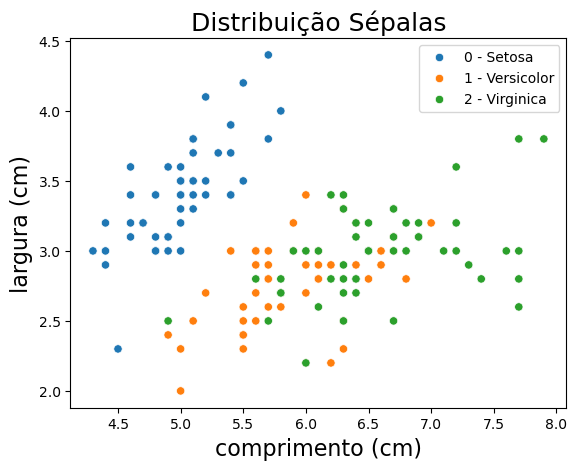

In [35]:
if __name__ == "__main__":
    sns.scatterplot(
        x=X_all[:, 0],   # petal length (cm)
        y=X_all[:, 1],   # petal width (cm)
        hue=y_all,
        palette="tab10"
    )

    plt.xlabel('comprimento (cm)', fontsize = 16)
    plt.ylabel('largura (cm)', fontsize = 16)
    plt.title('Distribuição Sépalas', fontsize = 18)

    nomes = ['0 - Setosa', '1 - Versicolor', '2 - Virginica']  # na mesma ordem de 0,1,2
    handles, labels = plt.gca().get_legend_handles_labels()
    # o primeiro label costuma ser o título automático ("hue")
    plt.legend(handles=handles[0:], labels=nomes)
    plt.show() 


## Análise da Distribuição das Sépalas

Do gráfico acima, observamos:

1) **Similaridade entre Versicolor e Virginica**: As espécies *Versicolor* e *Virginica* apresentam maior sobreposição nas medidas de sépalas comparadas à *Setosa*, dificultando sua distinção baseada apenas nessas características.

2) **Padrão dimensional por espécie**: 
   - *Setosa*: Sépalas mais largas
   - *Virginica*: Sépalas mais compridas
   
3) **Necessidade de normalização**: Observa-se variação significativa nas escalas de medidas (comprimento e largura), reforçando a importância da normalização dos dados para evitar viés no treinamento.

## Considerações sobre a Dimensionalidade do Problema

É importante destacar que os gráficos apresentados mostram apenas visualizações bidimensionais (2D) de um problema quadridimensional (4D):
- **Primeiro gráfico**: Comprimento vs. largura das pétalas
- **Segundo gráfico**: Comprimento vs. largura das sépalas

Durante o treinamento do modelo, todas as quatro dimensões são consideradas simultaneamente. O objetivo é que o modelo aprenda as relações complexas entre essas características através do ajuste de seus pesos e bias, capturando padrões que não são evidentes nas visualizações isoladas.

# Normalização dos dados

A partir dos gráficos apresentados, identificamos as seguintes variações nas medidas das características:

| Característica | Variação (cm) |
|---------------|---------------|
| Comprimento de sépalas | 4,3 a 7,9 |
| Largura de sépalas | 2,0 a 4,4 |
| Comprimento de pétalas | 1,0 a 6,9 |
| Largura de pétalas | 0,1 a 2,5 |

Notamos que a amplitude dos valores varia entre as diferentes características (de 0,1 cm até 7,9 cm). Esta disparidade pode introduzir vieses no processo de aprendizado, fazendo com que características com valores absolutos maiores tenham influência desproporcional no modelo.

Para garantir que todas as características contribuam de forma equilibrada para o treinamento, aplicaremos a normalização dos dados. Este pré-processamento é essencial tanto para o treinamento da rede neural quanto para algoritmos baseados em distância, como o K-means.

In [36]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_val = scaler.fit_transform(X_val)
X_train = scaler.fit_transform(X_train)
X_all = scaler.transform(X_all)

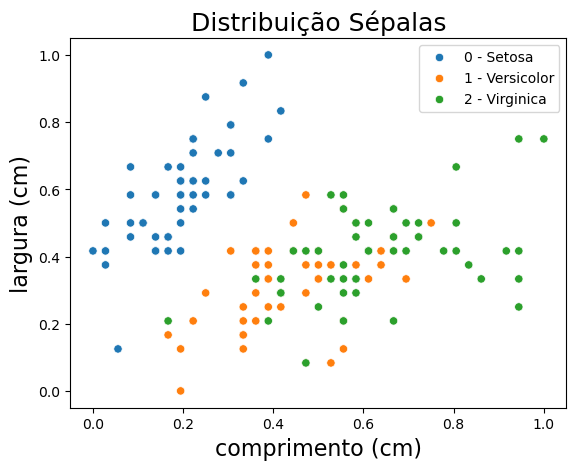

In [37]:
# Repare que os dados agora estão normalizados
if __name__ == "__main__":
    sns.scatterplot(
        x=X_all[:, 0],   # petal length (cm)
        y=X_all[:, 1],   # petal width (cm)
        hue=y_all,
        palette="tab10"
    )

    plt.xlabel('comprimento (cm)', fontsize = 16)
    plt.ylabel('largura (cm)', fontsize = 16)
    plt.title('Distribuição Sépalas', fontsize = 18)

    nomes = ['0 - Setosa', '1 - Versicolor', '2 - Virginica']  # na mesma ordem de 0,1,2
    handles, labels = plt.gca().get_legend_handles_labels()
    # o primeiro label costuma ser o título automático ("hue")
    plt.legend(handles=handles[0:], labels=nomes)
    plt.show() 

## Verificação da Normalização

Analisando os valores no gráfico acima, podemos observar que todas as características agora estão na mesma escala (0 a 1). Por exemplo, a largura das sépalas, que originalmente variava de aproximadamente 2,0 a 4,4 cm, agora está padronizada no intervalo [0, 1].

# Treinamento do Modelo Supervisionado

A seguir, implementaremos um modelo de rede neural para classificação supervisionada dos dados normalizados. 

In [38]:
modelo = keras.Sequential(
    [keras.layers.InputLayer(input_shape=[4,], name='entrada'),
     keras.layers.Dense(512, activation='relu', name='oculta', kernel_initializer = keras.initializers.RandomNormal(seed=142)),
     keras.layers.Dense(3,activation='softmax', name='saida')
     ]
)


## Arquitetura do Modelo

A rede neural definida acima possui a seguinte estrutura:

1. **Camada de entrada**: Dimensão 4, correspondente às quatro características do dataset Iris (comprimento da pétala, largura da pétala, comprimento da sépala e largura da sépala).

2. **Camada oculta**: Composta por 512 neurônios com função de ativação ReLU (*Rectified Linear Unit*). Esta função de ativação não linear permite que o modelo aprenda relações complexas entre as características de entrada, sendo essencial para a capacidade de generalização da rede.

3. **Inicialização dos pesos**: Utilizamos `kernel_initializer=RandomNormal(seed=142)` para inicializar os pesos da camada oculta com valores aleatórios provenientes de uma distribuição normal. A fixação da *seed* garante reprodutibilidade dos resultados, permitindo que múltiplas execuções do código produzam os mesmos resultados.

4. **Camada de saída**: Possui 3 neurônios (um para cada espécie: *setosa*, *versicolor* e *virginica*) com função de ativação *softmax*. Esta função transforma as saídas brutas da rede em probabilidades que somam 1, sendo ideal para problemas de classificação multiclasse.

In [39]:
modelo.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 oculta (Dense)              (None, 512)               2560      
                                                                 
 saida (Dense)               (None, 3)                 1539      
                                                                 
Total params: 4099 (16.01 KB)
Trainable params: 4099 (16.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Cálculo dos Parâmetros Treináveis

A quantidade total de parâmetros treináveis do modelo pode ser calculada considerando os pesos e bias de cada camada:

### Camada Oculta (512 neurônios)

Cada neurônio da camada oculta recebe como entrada as 4 características do dataset e possui um bias:
- **Pesos**: $4 \times 512 = 2.048$ parâmetros
- **Bias**: $512$ parâmetros
- **Total da camada**: $2.048 + 512 = 2.560$ parâmetros

**Cálculo alternativo**: $(4 + 1) \times 512 = 2.560$ parâmetros

### Camada de Saída (3 neurônios)

Cada neurônio da camada de saída recebe as saídas dos 512 neurônios da camada oculta e possui um bias:
- **Pesos**: $512 \times 3 = 1.536$ parâmetros
- **Bias**: $3$ parâmetros
- **Total da camada**: $1.536 + 3 = 1.539$ parâmetros

**Cálculo alternativo**: $(512 + 1) \times 3 = 1.539$ parâmetros

### Total Geral

**Parâmetros totais do modelo**: $2.560 + 1.539 = 4.099$ parâmetros

Este valor pode ser verificado confome o comando `modelo.summary()`, executado acima.

In [40]:
# Convert labels to one-hot encoded format
y_train_cat = keras.utils.to_categorical(y_train, num_classes=3)
y_val_cat = keras.utils.to_categorical(y_val, num_classes=3)

modelo.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop',
              metrics=['categorical_accuracy'])

historico = modelo.fit(X_train, y_train_cat, 
          epochs=100,
          validation_data=(X_val, y_val_cat))

Epoch 1/100
4/4 [==============================] - 1s 66ms/step - loss: 1.0577 - categorical_accuracy: 0.5583 - val_loss: 0.9841 - val_categorical_accuracy: 0.6667
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 0.9781 - categorical_accuracy: 0.6750 - val_loss: 0.9229 - val_categorical_accuracy: 0.6667
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 0.9244 - categorical_accuracy: 0.6667 - val_loss: 0.8729 - val_categorical_accuracy: 0.6667
Epoch 4/100
4/4 [==============================] - 0s 11ms/step - loss: 0.8799 - categorical_accuracy: 0.6667 - val_loss: 0.8277 - val_categorical_accuracy: 0.6667
Epoch 5/100
4/4 [==============================] - 0s 12ms/step - loss: 0.8423 - categorical_accuracy: 0.6667 - val_loss: 0.7874 - val_categorical_accuracy: 0.6667
Epoch 6/100
4/4 [==============================] - 0s 12ms/step - loss: 0.8075 - categorical_accuracy: 0.6667 - val_loss: 0.7505 - val_categorical_accuracy: 0.6667
Epoch 7/100
4/4 

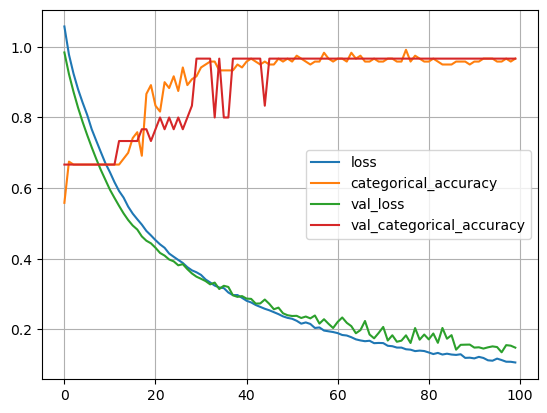

In [41]:

pd.DataFrame(historico.history).plot()
plt.grid()
plt.show()

## Interpretação dos Resultados

A análise das curvas de treinamento permite concluir que o modelo foi treinado adequadamente:

1. **Convergência**: As curvas de *loss* (perda) dos conjuntos de treinamento e validação apresentam comportamento decrescente, indicando que o modelo está generalizando bem e não apresenta sinais de *overfitting*.

2. **Alto desempenho**: Ambas as métricas de acurácia (treinamento e validação) convergem para valores próximos de 1,0 (100%), demonstrando excelente capacidade de classificação para o problema em questão.

Este resultado serve como referência (*baseline*) para comparação com a abordagem não supervisionada que será implementada a seguir.

# Aprendizado Não Supervisionado 


In [42]:
# 1) normalizar dados
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_all_s   = scaler.transform(X_all)

def build_autoencoder(input_dim=4, latent_dim=3, hidden_dim=16, activation="relu"):
    inp = keras.Input(shape=(input_dim,))
    # encoder
    x = keras.layers.Dense(hidden_dim, activation=activation)(inp)
    z = keras.layers.Dense(latent_dim, activation=None, name="latent")(x)
    # decoder
    x = keras.layers.Dense(hidden_dim, activation=activation)(z)
    out = keras.layers.Dense(input_dim, activation="linear")(x)

    auto = keras.Model(inp, out)
    enc = keras.Model(inp, z)
    auto.compile(optimizer="adam", loss="mse")
    return auto, enc

# 2) treinar
auto, encoder = build_autoencoder(input_dim=4, latent_dim=3, hidden_dim=16)
auto.fit(
    X_train_s, X_train_s,
    validation_data=(X_val_s, X_val_s),
    epochs=200,          
    batch_size=16,
    verbose=0
)

# 3) extrair latente e clusterizar
Z = encoder.predict(X_all_s)

kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(Z)

# labels: vindo do k-means
# y_all: rótulos verdadeiros do iris

def cluster_accuracy(y_true, y_pred):
    mapped = np.zeros_like(y_pred)
    for c in np.unique(y_pred):
        # pega as classes verdadeiras dos pontos que caíram no cluster c
        mask = (y_pred == c)
        true_in_cluster = y_true[mask]
        # classe mais comum nesse cluster
        most_common = Counter(true_in_cluster).most_common(1)[0][0]
        mapped[mask] = most_common
    acc = (mapped == y_true).mean()
    return acc, mapped

acc, y_pred_aligned = cluster_accuracy(y_all, labels)
print("Acurácia de clustering (com alinhamento):", acc)

uniq = np.unique(labels)
print("Clusters formados:", uniq)

if len(uniq) < 2:
    print("Ainda formou só 1 cluster. Aumente epochs ou latent_dim.")
else:
    sil = silhouette_score(Z, labels)
    cal = calinski_harabasz_score(Z, labels)
    dav = davies_bouldin_score(Z, labels)

    print("Silhouette:", sil)
    print("Calinski-Harabasz:", cal)
    print("Davies-Bouldin:", dav)

    # Guardando para fazer gráfico mais abaixo
    metrics_baseline = {
        "acuracia": float(acc),
        "silhouette": float(sil),
        "calinski": float(cal),
        "davies": float(dav),
    }

5/5 [==============================] - 0s 1ms/step
Acurácia de clustering (com alinhamento): 0.84
Clusters formados: [0 1 2]
Silhouette: 0.5096197724342346
Calinski-Harabasz: 452.1598096274234
Davies-Bouldin: 0.7328237369983047


## Análise dos Resultados do Clustering Baseline

A seguir, apresentamos uma análise detalhada das métricas obtidas pelo modelo não supervisionado (autoencoder + K-means):

### 1. Acurácia de Clustering: 0,84 (84%)

A acurácia obtida é inferior àquela alcançada pelo MLP supervisionado. Esta diferença é esperada e reflete a natureza fundamental do experimento: o modelo **nunca teve acesso aos rótulos  durante o treinamento**. O autoencoder aprendeu exclusivamente a reconstruir os dados de entrada, e o K-means posteriormente agrupou as representações latentes em 3 clusters. 


### 2. Clusters Formados: [0, 1, 2]

O algoritmo K-means identificou com sucesso **3 grupos distintos**, correspondendo ao número esperado de classes no dataset Iris.

### 3. Coeficiente de Silhouette: 0,5096

Para dados reais com sobreposição natural entre classes (como observado entre *Versicolor* e *Virginica*), este resultado é satisfatório. Este resultado serve como baseline e será alvo de otimização nas próximas etapas.

### 4. Índice de Calinski-Harabasz: 452,16

O valor obtido (452,16) é considerado elevado, indicando que:
- Os pontos apresentam **alta coesão interna** (compactos dentro de cada cluster)
- Existe **boa separação externa** (distância significativa entre os centros dos clusters)

### 5. Índice de Davies-Bouldin: 0,73

Um valor de 0,73 indica que os clusters são **razoavelmente compactos e bem separados**. Valores inferiores a 1,0 são geralmente considerados aceitáveis, sugerindo que a razão entre dispersão interna e separação externa dos clusters está equilibrada.


# Otimização de Hiperparâmetros com Optuna

Nesta etapa, aplicaremos otimização através da biblioteca Optuna para identificar a melhor configuração de hiperparâmetros. O objetivo é maximizar a qualidade dos clusters formados.

In [43]:
# Configuração de seeds para reprodutibilidade
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

def objective(trial):
    """Função objetivo para otimização com Optuna."""
    # Hiperparâmetros que o Optuna vai testar
    latent_dim = trial.suggest_int("latent_dim", 2, 4)
    hidden_dim = trial.suggest_int("hidden_dim", 8, 32)
    activation = trial.suggest_categorical("activation", ["relu", "tanh"])

    # Constrói o autoencoder
    inp = keras.Input(shape=(4,))
    x = keras.layers.Dense(hidden_dim, activation=activation)(inp)
    z = keras.layers.Dense(latent_dim, activation=None, name="latent")(x)
    x = keras.layers.Dense(hidden_dim, activation=activation)(z)
    out = keras.layers.Dense(4, activation="linear")(x)
    
    auto = keras.Model(inp, out)
    encoder = keras.Model(inp, z)
    auto.compile(optimizer="adam", loss="mse")

    # Treina o modelo
    auto.fit(
        X_train_s, X_train_s,
        validation_data=(X_val_s, X_val_s),
        epochs=80,
        batch_size=16,
        verbose=0
    )

    # Extrai representação latente
    Z = encoder.predict(X_all_s, verbose=0)

    # Aplica K-means
    kmeans = KMeans(n_clusters=3, random_state=42)
    labels = kmeans.fit_predict(Z)

    # Verifica se formou clusters válidos
    if len(np.unique(labels)) < 2:
        trial.set_user_attr("silhouette", -1.0)
        trial.set_user_attr("calinski_harabasz", None)
        trial.set_user_attr("davies_bouldin", None)
        trial.set_user_attr("accuracy", None)
        return -1.0

    # Calcula métricas
    sil = silhouette_score(Z, labels)
    cal = calinski_harabasz_score(Z, labels)
    dav = davies_bouldin_score(Z, labels)

    # Calcula acurácia alinhando clusters com classes verdadeiras
    mapped = np.zeros_like(labels)
    for c in np.unique(labels):
        mask = labels == c
        most_common = Counter(y_all[mask]).most_common(1)[0][0]
        mapped[mask] = most_common
    acc = (mapped == y_all).mean()

    # Armazena métricas no trial
    trial.set_user_attr("silhouette", float(sil))
    trial.set_user_attr("calinski_harabasz", float(cal))
    trial.set_user_attr("davies_bouldin", float(dav))
    trial.set_user_attr("accuracy", float(acc))
    trial.set_user_attr("Z", Z.tolist())
    trial.set_user_attr("labels", labels.tolist())

    return sil

# Configura e executa otimização
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

# Recupera resultados do melhor trial
best_trial = study.best_trial

print('RESULTADOS DA OTIMIZAÇÃO COM OPTUNA')
print(f"Melhor trial:             {best_trial.number}")
print(f"Silhouette Score:         {best_trial.user_attrs['silhouette']:.4f}")
print(f"Calinski-Harabasz:        {best_trial.user_attrs['calinski_harabasz']:.2f}")
print(f"Davies-Bouldin:           {best_trial.user_attrs['davies_bouldin']:.4f}")
print(f"Acurácia:       {best_trial.user_attrs['accuracy']:.4f} ({best_trial.user_attrs['accuracy']*100:.2f}%)")

# Armazena métricas para comparação
metrics_optuna = {
    "acuracia": float(best_trial.user_attrs["accuracy"]),
    "silhouette": float(best_trial.user_attrs["silhouette"]),
    "calinski": float(best_trial.user_attrs["calinski_harabasz"]),
    "davies": float(best_trial.user_attrs["davies_bouldin"])
}


RESULTADOS DA OTIMIZAÇÃO COM OPTUNA
Melhor trial:             15
Silhouette Score:         0.6980
Calinski-Harabasz:        1333.82
Davies-Bouldin:           0.4310
Acurácia:      0.8867 (88.67%)


# Comparação entre Baseline e Otimização

A seguir, apresentamos uma análise comparativa entre o desempenho do modelo baseline e o modelo otimizado através do Optuna 

In [44]:
print(
f"""| {'Treinamento':<21} | {'Tradicional':<13} | {'Optuna':<11} |
|{'-'*23}|{'-'*15}|{'-'*13}|
| {'Acurácia':<21} | {f"{metrics_baseline['acuracia']*100:.1f}".replace('.', ',') + '%':<13} | {f"{metrics_optuna['acuracia']*100:.1f}".replace('.', ',') + '%':<11} |
| {'Silhouette':<21} | {f"{metrics_baseline['silhouette']:.4f}".replace('.', ','):<13} | {f"{metrics_optuna['silhouette']:.4f}".replace('.', ','):<11} |
| {'Davies–Bouldin':<21} | {f"{metrics_baseline['davies']:.5f}".replace('.', ','):<13} | {f"{metrics_optuna['davies']:.5f}".replace('.', ','):<11} |
| {'Calinski–Harabasz':<21} | {f"{metrics_baseline['calinski']:.2f}".replace('.', ','):<13} | {f"{metrics_optuna['calinski']:.2f}".replace('.', ','):<11} |"""
)


| Treinamento           | Tradicional   | Optuna      |
|-----------------------|---------------|-------------|
| Acurácia              | 84,0%         | 88,7%       |
| Silhouette            | 0,5096        | 0,6980      |
| Davies–Bouldin        | 0,73282       | 0,43098     |
| Calinski–Harabasz     | 452,16        | 1333,82     |


## Análise Comparativa dos Resultados


O modelo otimizado com Optuna apresentou melhoria em todas as métricas de separação de clusters e também uma leve melhora de acurácia, conforme veremos abaixo:


**Coeficiente de **Silhouette Score**  
O aumento de 0,51 para 0,70 com o Optuna mostra que, em média, os pontos ficaram mais coerentes dentro de seus clusters.

**Índice de Davies-Bouldin**  
Uma queda de 0,73 para 0,43 indica que os clusters estão mais coesos e com uma melhor distribuição entre eles.

**Índice de Calinski-Harabasz**  
O aumento de 452,16 para 1333,82 indica que, após a otimização, os clusters ficaram bem mais compactos internamente e/ou mais bem separados entre si — coerente com o ganho de Silhouette e a queda do Davies-Bouldin.


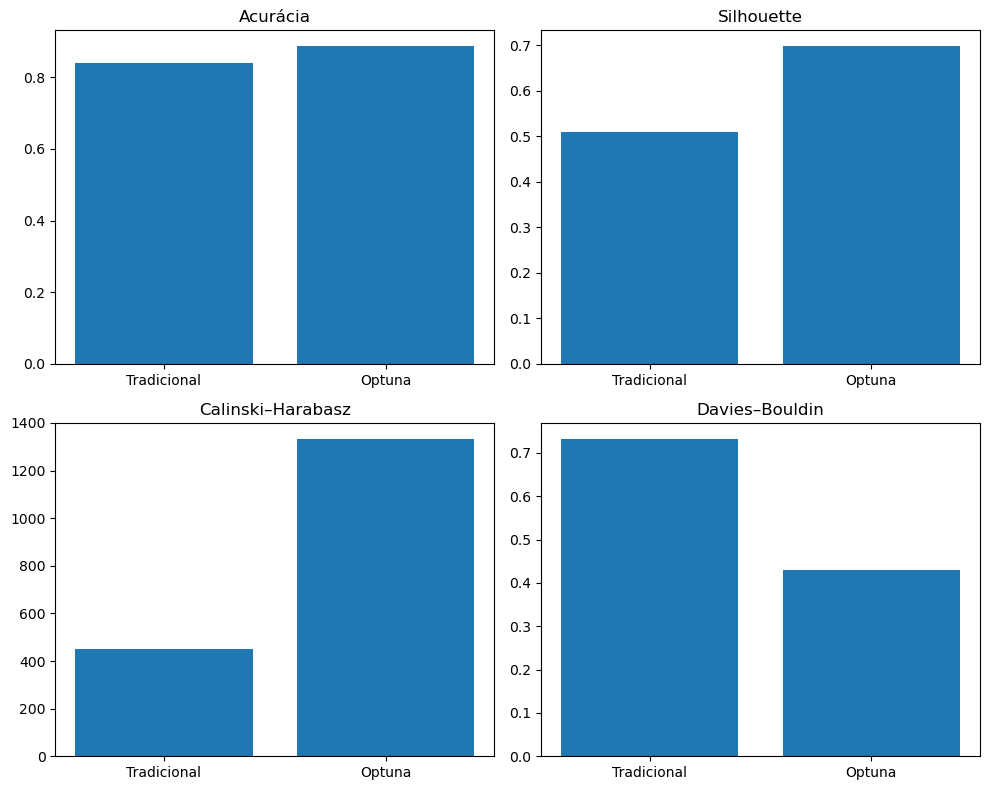

In [45]:


# garante que os dois existem
if metrics_baseline is None:
    raise ValueError("Baseline não gerou métricas (k-means colapsou).")

metric_names = ["acuracia", "silhouette", "calinski", "davies"]
titles = {
    "acuracia": "Acurácia",
    "silhouette": "Silhouette",
    "calinski": "Calinski–Harabasz",
    "davies": "Davies–Bouldin",
}

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.ravel()

for i, m in enumerate(metric_names):
    trad = metrics_baseline[m]
    optu = metrics_optuna[m]

    axs[i].bar(["Tradicional", "Optuna"], [trad, optu])
    axs[i].set_title(titles[m])

plt.tight_layout()
plt.show()



# Conclusão

Os gráficos acima demonstram que a utilização do Optuna levou a uma **melhoria na representação dos clusters**, alcançando ganhos em todas as métricas analisadas. 

Este resultado demonstra que técnicas de aprendizado não supervisionado podem capturar a maior parte dos padrões dos dados de forma adequada, representando uma alternativa viável em cenários onde a rotulação manual é custosa ou inviável. 
